*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Excitatory-Inhibitory Spiking Neural Network with Lava

_**Motivation**: In this tutorial, we will build a Lava Process for a spiking neural
network of excitatory and inhibitory neurons (E/I network) using the Lava Processes for LIF
neurons and Dense connectivity. The tutorial is useful to get started with Lava in a few minutes._

#### This tutorial assumes that you:
- have the [Lava framework installed](../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")

#### This tutorial gives a bird's-eye view of
- how with Lava you can implement a simple E/I Network using
[Leaky Integrate-and-Fire (LIF)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") neurons and [Dense
(fully connected)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") connectivity.
- how to use Hierarchical Process to build more complicated Processes from simpler ones
- how to create a SubProcessModels for this Hierarchical Process using already defined ProcessModels for a swift execution


(Add diagram) </br>

#### E/I Network
In this tutorial, we build a Lava Process for an E/I network. E/I networks are fundamental examples of recurrent spiking neural networks mimicking the structure of the brain and exhibting rich dynamical behavior. </br>
As depicted above, the network consists of LIF neurons which are connected to a dense layer with specified weights which again connectes to the LIF neurons. </br>
With an additional inpurt one can feed in external activations into the network, the outport allows for reading out spikes.

#### General imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

#### E/I Network Lava Process
We define the structure of the E/I Network Lava Hierarchical Process class. </br>
The definition reflects the structure of the Lava Processes used to build the Hierarchical Process. </br>

In [2]:
# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

In [3]:
class EINetwork(AbstractProcess):
    """Network of recurrently connected neurons
    with given weight matrix
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (1,))
        du = kwargs.pop("du", 0)
        dv = kwargs.pop("dv", 0)
        vth = kwargs.pop("vth", 10)
        bias_mant = kwargs.pop("bias_mant", 0)
        bias_exp = kwargs.pop("bias_exp", 0)
        weights = kwargs.pop("weights", 0)
        
        # Ports for receiving input or sending output
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)

        # Variables for LIF Process
        self.du = Var(shape=(1,), init=du)
        self.dv = Var(shape=(1,), init=dv)
        self.vth = Var(shape=(1,), init=vth)
        self.bias_mant = Var(shape=shape, init=bias_mant)
        self.bias_exp = Var(shape=shape, init=bias_exp)
        
        # Variable for Dense Process
        self.weights = Var(shape=(shape[0], shape[0]), init=weights)

#### ProcessModels for Python execution

In [4]:
# Import parent classes for ProcessModels for Hierarchical Processes
from lava.magma.core.model.sub.model import AbstractSubProcessModel

# Import execution protocol
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol

# Import decorators
from lava.magma.core.decorator import implements

#### E/I Network Subprocess Model
Using the behavior defined for the [LIF](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") and [Dense](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") Processes, we define the behavior of the E/I Network Process. </br>

In [5]:
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF

@implements(proc=EINetwork, protocol=LoihiProtocol)
class SubEINetworkModel(AbstractSubProcessModel):
    def __init__(self, proc):
        shape = proc.proc_params.get("shape", (1,))
        du = proc.proc_params.get("du", (1,))
        dv = proc.proc_params.get("dv", (1,))
        vth = proc.proc_params.get("vth", (1,))
        bias_mant = proc.proc_params.get("bias_mant", (1,))
        bias_exp = proc.proc_params.get("bias_exp", (1,))
        weights = proc.proc_params.get("weights", (1,))

        # Instantiate LIF and Dense Lava Processes
        self.lif = LIF(shape=shape,
                       du=du,
                       dv=dv,
                       vth=vth,
                       bias_mant=bias_mant,
                       bias_exp=bias_exp)
        self.dense = Dense(weights=weights)
            
        # Recurrently connect neurons to E/I Network
        self.lif.out_ports.s_out.connect(self.dense.in_ports.s_in)
        self.dense.out_ports.a_out.connect(self.lif.in_ports.a_in)

        # Connect incoming activation to neurons and elicited spikes to ouport
        proc.in_ports.a_in.connect(self.lif.in_ports.a_in)
        self.lif.out_ports.s_out.connect(proc.out_ports.s_out)

#### Defining the parameters for the network
We define the parameters for the single neurons as well as the recurrent connectivity of the neurons. </br>
The recurrent weights encode the difference between excitatory and inhibitory neurons. </br>
Moreover, the weights must *balance* the network, i.e. the average recurrent input to a neuron must be less or equal than $0$.  Otherwise, the network activity is caught up in a positive feedback loop and explodes. </br>
We here follow the common choice that the ration $\gamma$ between the number of excitatory and inhibitory neurons equals $4$ and that the connection probability between two arbitrary neurons is identical. 

In [6]:
# Fix randomness
np.random.seed(1234)

# Fix network size
num_neurons = 300
shape = (num_neurons,)

# Single neuron paramters
# Bias_mant is set to make the neuron spike
lif_params = {
    "vth": 1,
    "du": 0.01,
    "dv": 0.1,
    "bias_mant": 0.101}

# inhibition-exciation balance for scaling inhibitory weights to maintain balance (4 times as many excitatory neurons)
g = 4

# Generate connectivity
# W[i, j] is connection weight from pre-synaptic neuron j to post-synaptic neuron i
# Set scaled standard deviation of recurrent weights
J = 0.5 / np.sqrt(num_neurons)
weights = np.random.normal(0, J, (num_neurons, num_neurons)) * lif_params['du']

# Impose constraint that neurons can **either** be excitatory (positive weight) **or** inhibitory (negative weight)
# We use the commen choice of 4 times as many (i.e. 80%) excitatory neurons
n_exc = int(num_neurons * 0.8)
mask_pos_weights = (weights > 0)
mask_neg_weights = (weights < 0)

exc_conns = np.full(weights.shape, True)
exc_conns[:, n_exc:] = False # Set entries for inhibitory neurons to False
inh_conns = np.invert(exc_conns)

# Set negative weights of exciatory neurons to zero and similarly for inhibitory neurons -> induce sparsity
weights[mask_neg_weights * exc_conns] = 0
weights[mask_pos_weights * inh_conns] = 0

# We finally need to increase the inhibitory weights by a factor of 4 to maintain balance
weights[inh_conns] *= g

# Parameters Paramters for E/I network
ei_network_params = {"shape": shape, "weights": weights, **lif_params}

#### Execution and Results

In [8]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
# Import io processes
from lava.proc.io import sink, source

# Configurations for execution
num_steps = 500
rcfg = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)
run_cond = RunSteps(num_steps=num_steps)

# Instantiating network and IO processes
network = EINetwork(**ei_network_params)
inport_plug = source.RingBuffer(data=np.zeros((num_neurons, 1)))
outport_plug = sink.RingBuffer(shape=shape, buffer=num_steps)

inport_plug.s_out.connect(network.a_in)
network.s_out.connect(outport_plug.a_in)

network.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks = outport_plug.data.get()

network.stop()

#### Visualizing the acitvity
First, we visually inspect to spiking activity of the neurons in the network.
To this end, we display neurons on the vertical axis and mark the time step when a neuron spiked.

In [9]:
def raster_plot(spks, stride=6):
    """Generate raster plot of spiking activity
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    stride : int
        Stride for plotting neurons
    """
    num_time_steps = spks.shape[1]
    assert stride < num_time_steps, "Stride must be smaller then number of time steps"
    
    time_steps = np.arange(0, num_time_steps, 1)
    
    plt.figure(figsize=(10,5))
    timesteps = spks.shape[1]
    
    plt.xlim(-1, num_time_steps)
    plt.yticks([])
    
    plt.xlabel('Time steps')
    plt.ylabel('Neurons')
    
    for i in range(0, num_neurons, stride):
        spike_times = time_steps[spks[i] == 1]
        plt.plot(spike_times,
                 i * np.ones(spike_times.shape),
                 linestyle=' ',
                 marker='o',
                 markersize=1.5,
                 color='b')
        
        

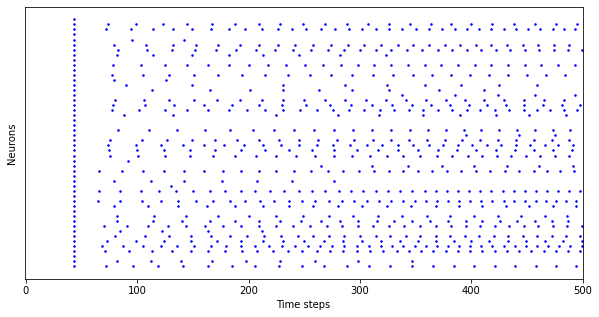

In [10]:
raster_plot(spks=spks)

After an initial synchronous burst (all neurons are simultaneously driven to the threshold by the external current), we observe an immediate decoupling of the single neuron activities due to the recurrent connectivity. </br>
Overall, we see a heterogeneous network state with asynchronous spiking across neurons. </br>

#### Further analysis
Another hallmark property of the network activity is the *auto-correlation function* $c(\tau)$. </br>
With this function, one can assess the *memory* of the network. </br>
Denoting the network activity by $a$, the *auto-correlation function* is the Pearson correlation (here denoted $\mathrm{Corr}(\cdot, \cdot)$) of $a$ with a time shifted version of itself: </br>
\begin{equation}
    c(\tau) = \mathrm{Corr}(a(t), a(t+\tau))
\end{equation}
This means for positive $\tau$ the value of the auto-correlation function gives a measure for the similarity of the network state $a(t)$ and $a(t+\tau)$. </br>
If $c(\tau)$ is significantly greater than zero for large $\tau$, the network has *memory* of its previous states.

In [11]:
from scipy.stats import pearsonr

def auto_corr_fct(spks, max_lag):
    """Auto-correlation function of parallel spike trains
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    max_lag : int
        Maximal lag for compuation of auto-correlation function
        
    Returns:
    
    lags : np.ndarray
        lags for auto-correlation function
    auto_corr_fct : np.ndarray
        auto-correlation function
    """
    assert max_lag < spks.shape[1], 'Maximal lag must be smaller then total number of time points'
    auto_corr_fct = np.zeros(2 * max_lag + 1)
    lags = np.linspace(-1 * max_lag, max_lag, 2 * max_lag + 1, dtype=int)
    
    for i, lag in enumerate(lags):
        shifted_spks = np.roll(spks, shift=lag, axis=1)
        auto_corrs = np.zeros(spks.shape[0])
        for j, spk in enumerate(spks):
            auto_corrs[j] = pearsonr(spk, shifted_spks[j])[0]
        auto_corr_fct[i] = np.mean(auto_corrs)
        
    return lags, auto_corr_fct
    
    

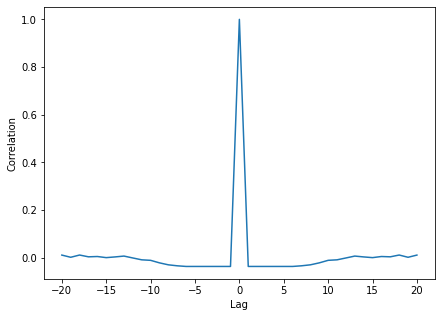

In [12]:
lags, ac_fct = auto_corr_fct(spks=spks, max_lag=20)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct)

As expected, there is perfect correlation at a time lag of $0$. </br>
We moreover see that for positive time lags the correlation is close to zero. </br>
This means that the network has no memory of its previous states: Already after one time step we lost almost all information of the previous network state. </br>
Such a network is unfit to perform meaningful computation.

#### Controlling the network
One of the main control parameters we can tune for the above network is the strength of the recurrent weights. </br>
Increasing the weights by scaling them up and leaving the rest (also the existence) of connections unchanged leads to a fundamentally different network state.

In [13]:
# Changing the strenghts of the recurrent connections
ei_network_params['weights'] = 1e2 * ei_network_params['weights']

# Configurations for execution
num_steps = 500
rcfg = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)
run_cond = RunSteps(num_steps=num_steps)

# Creating new new network with changed weights
network_strong_weights = EINetwork(**ei_network_params)
inport_plug_strong_weights = source.RingBuffer(data=np.zeros((num_neurons, 1)))
outport_plug_strong_weights = sink.RingBuffer(shape=shape, buffer=num_steps)

inport_plug_strong_weights.s_out.connect(network_strong_weights.a_in)
network_strong_weights.s_out.connect(outport_plug_strong_weights.a_in)

network_strong_weights.run(condition=run_cond, run_cfg=rcfg)

# Fetching spiking activity
spks_strong_weights = outport_plug_strong_weights.data.get()

network.stop()

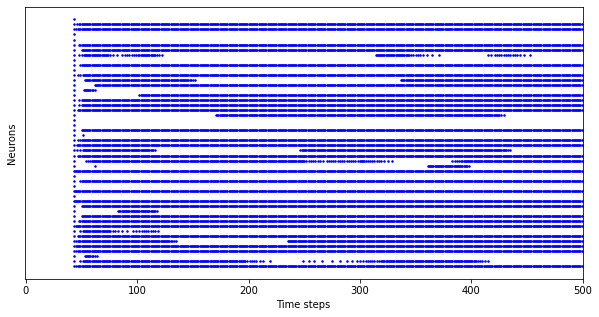

In [14]:
raster_plot(spks=spks_strong_weights)

Here we see a qualitatively different network activity where the recurrent connections play a more dominant role: </br>
At seemingly random times, single neurons enter into active states of variable length. </br>
Next, we have a look at the auto-correlation function of the network.

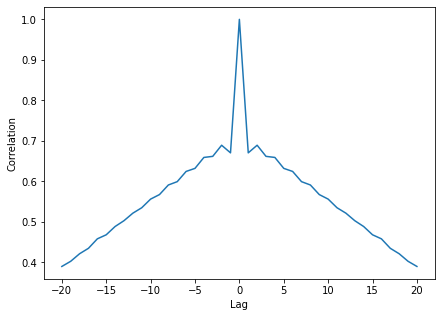

In [15]:
lags, ac_fct_strong_weights = auto_corr_fct(spks=spks_strong_weights, max_lag=20)

# Plotting the auto-correlation function
plt.figure(figsize=(7,5))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.plot(lags, ac_fct_strong_weights)

We observe a slowly decaying auto-correlation function. </br>
These long-lasting temporal correlations are related to a critical network state and the edge of chaos: different inital conditions have a long-lasting effect on the network activity. </br>
This implies the network is in a suitable regime for computation, e.g. in the context of reservoir computing.